In [32]:
import sklearn
import matplotlib.pyplot as plt
from training.sigopt_utils import build_sigopt_name
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import random
from pymatgen.core import Structure

In [59]:
def check_if_rocksalt(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if dist == 4.0 and struct.species[j]==struct.species[i]:
                    return False
                
    return True

def get_is_rocksalt(df):
    is_rocksalt = []
    
    for i in range(len(df)):
        is_rocksalt.append(check_if_rocksalt(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_rocksalt

In [60]:
def get_np_embedding(df):
    curr_embeddings = df["embedding_0"]
    
    arr_list = []
    for embedding in curr_embeddings:
        arr_list.append(np.asarray(embedding[0]))
    np_embedding = np.asarray(arr_list)
    
    return np_embedding

In [67]:

def embeddings_from_file(param,test):
    exp_id = param["exp_id"]
    idx = 0
    sigopt_name = build_sigopt_name("data/", "dft_e_hull", param["struct_type"], param["interpolation"], param["model_type"])
    directory = "./best_models_ver_Aug04/" + param["model_type"] + "/" + sigopt_name + "/" +str(exp_id) + "/" + "best_" + str(idx)
    data = pd.read_json(directory + '/' + test + "_embeddings"+"_"+str(0)+".json")
    return data

def get_pca(param,test,num_comps=6,star_rocksalt=True):
    embeddings = embeddings_from_file(param,test)
    np_embedding = get_np_embedding(embeddings)
    
    pca = PCA(n_components=2)
    pca.fit(np_embedding)
    projection = pca.transform(np_embedding)
    
    random.seed(10)
    selected_forms = random.sample(list(embeddings["formula"]), num_comps)
    selected_colors = []
    projection_featured = []
    projection_ordering = []
    
    for i in range(len(selected_forms)):
        curr_form = selected_forms[i]
        
        
        filtered_embeddings = embeddings[embeddings["formula"]==curr_form]
        filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
        
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        curr_ordering = list(filtered_embeddings["is_rocksalt"])
        
        projection_featured.append(curr_projection)
        projection_ordering.append(curr_ordering)
        curr_color = np.ones(curr_projection.shape[0])*i
        selected_colors.append(curr_color)
        
    
    background_embeddings = embeddings[~embeddings["formula"].isin(selected_forms)]
    np_background_embeddings = get_np_embedding(background_embeddings)
    projection_background = pca.transform(np_background_embeddings)
    
    plt.scatter(projection_background[:,0],projection_background[:,1],c="black",alpha=0.02)
    for i in range(len(projection_featured)):
        if star_rocksalt:
            for j in range(len(projection_featured[i][:,0])):
                if j == 0:
                    curr_label = selected_forms[i]
                else:
                    curr_label = None
                if projection_ordering[i][j]:
                    plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='*',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8)
                else:
                    plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],s=40,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8)
        
        else:
            plt.scatter(projection_featured[i][:,0],projection_featured[i][:,1],c=selected_colors[i],label=selected_forms[i],vmin=0.0,vmax=num_comps,alpha=0.8)

    plt.xlabel("PCA Component 1",size = 15)
    plt.ylabel("PCA Component 2",size = 15)
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
    

In [68]:
all_params = [
{"model_type": "CGCNN", "interpolation": False, "struct_type": "unrelaxed", "exp_id": 837611},
{"model_type": "CGCNN", "interpolation": False, "struct_type": "relaxed", "exp_id": 837612},
{"model_type": "CGCNN", "interpolation": False, "struct_type": "M3Gnet_relaxed", "exp_id": 837613},

{"model_type": "e3nn", "interpolation": False, "struct_type": "unrelaxed", "exp_id": 837627},
{"model_type": "e3nn", "interpolation": False, "struct_type": "relaxed", "exp_id": 837628},
{"model_type": "e3nn", "interpolation": False, "struct_type": "M3Gnet_relaxed", "exp_id": 837629},
]

all_tests = ["test_set","holdout_set_series","holdout_set_B_sites"]

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

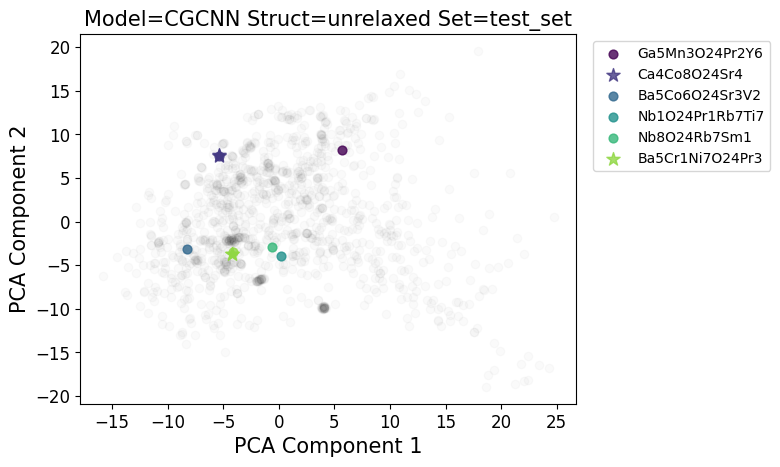

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

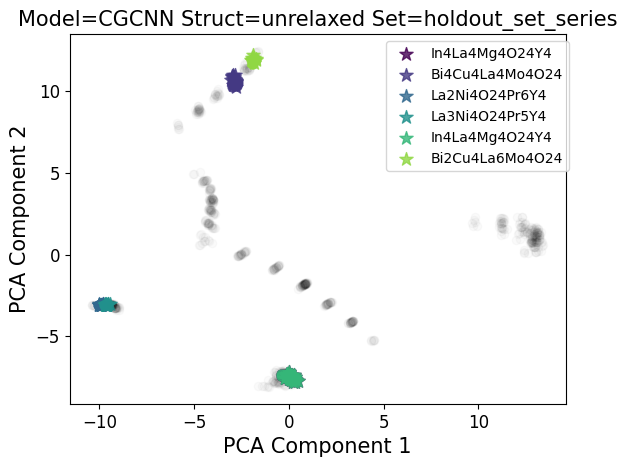

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

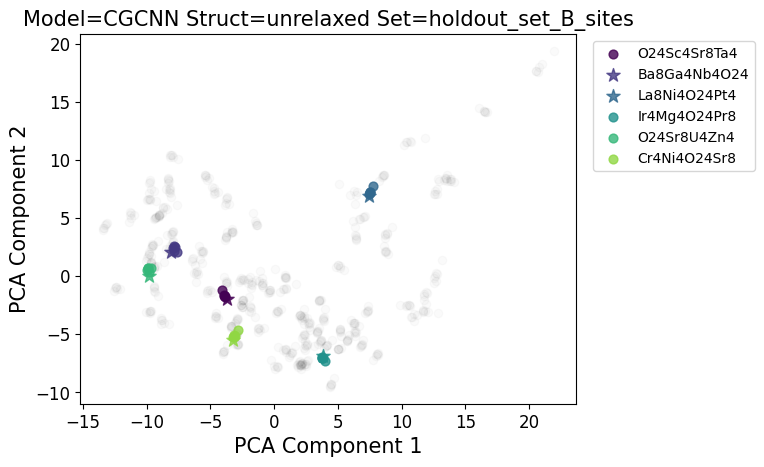

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

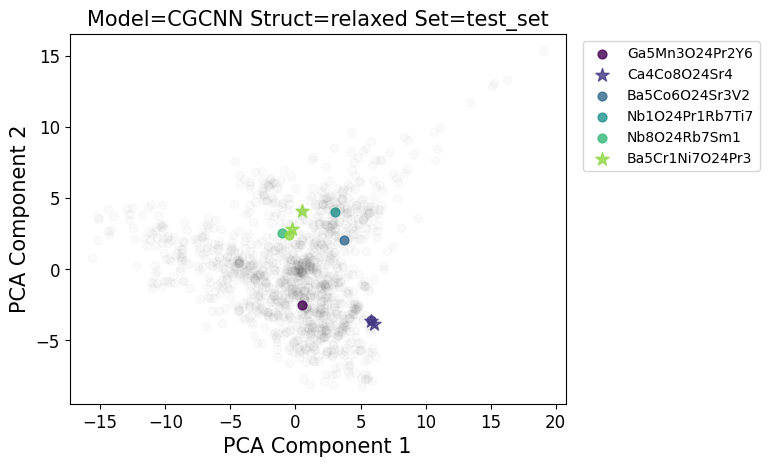

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

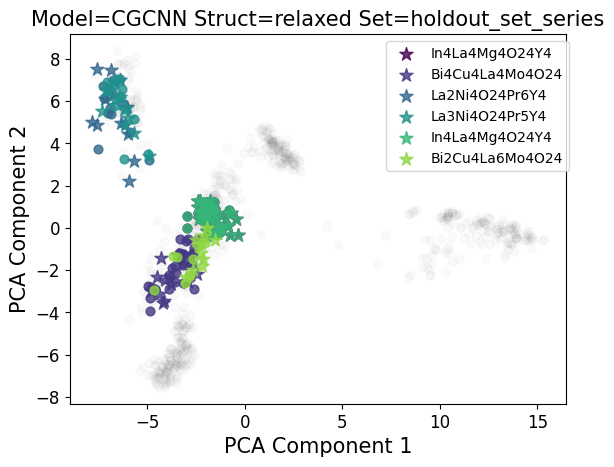

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

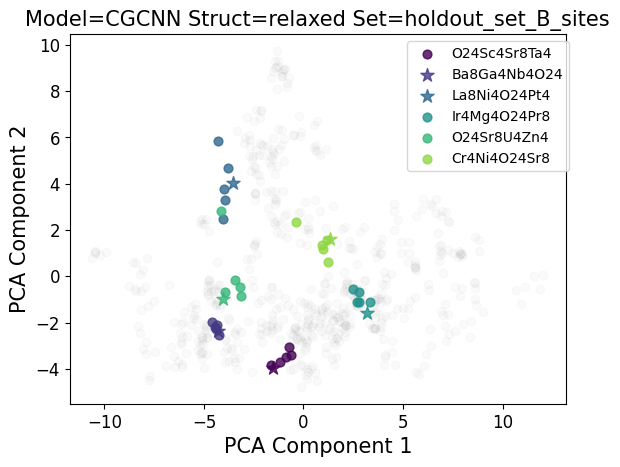

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

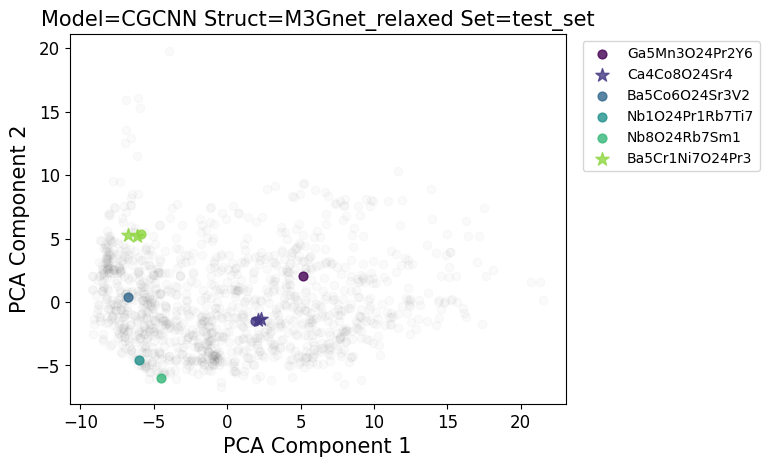

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

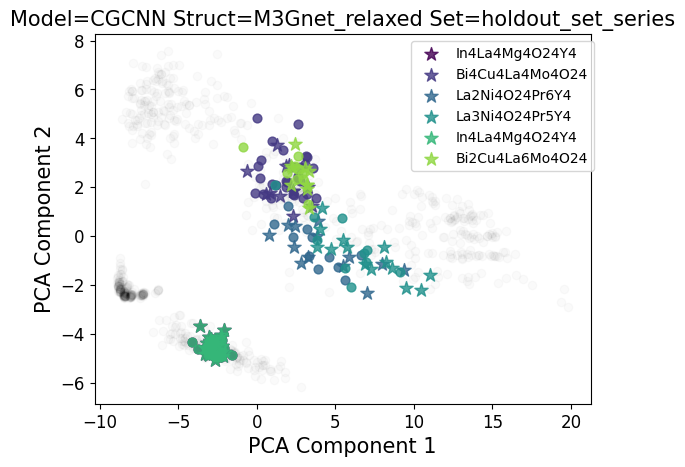

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

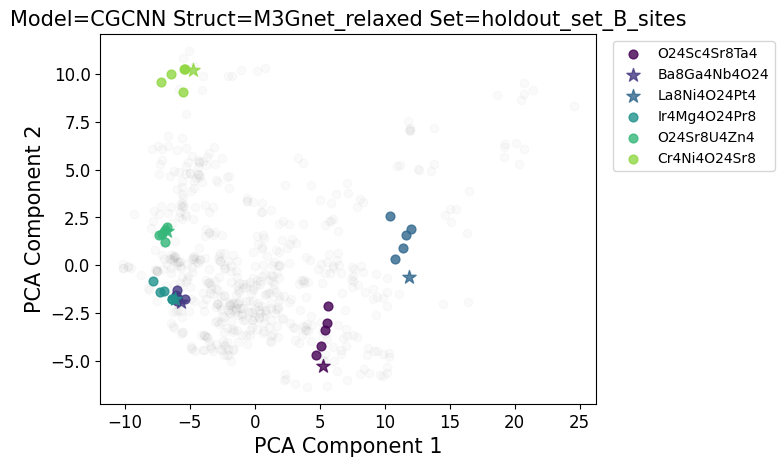

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

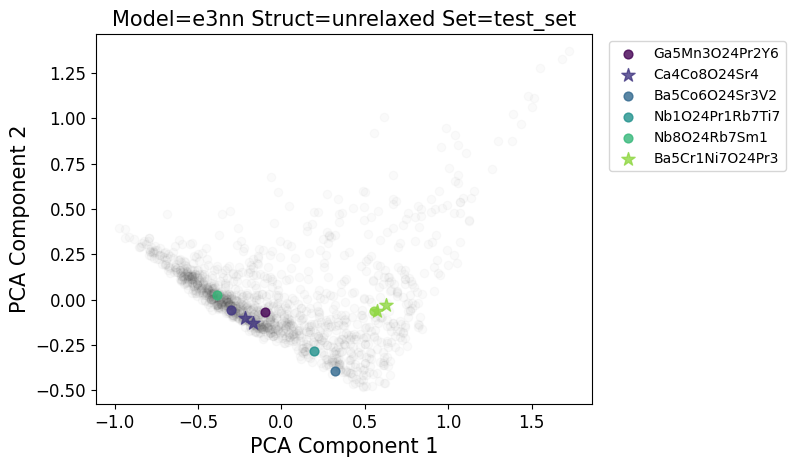

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

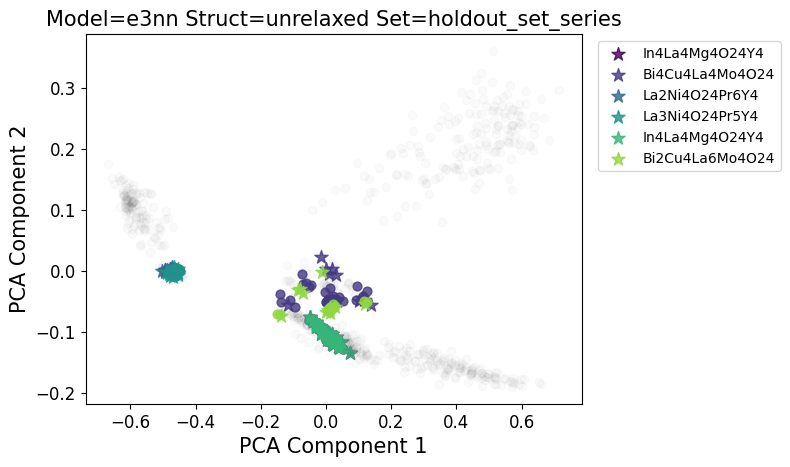

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

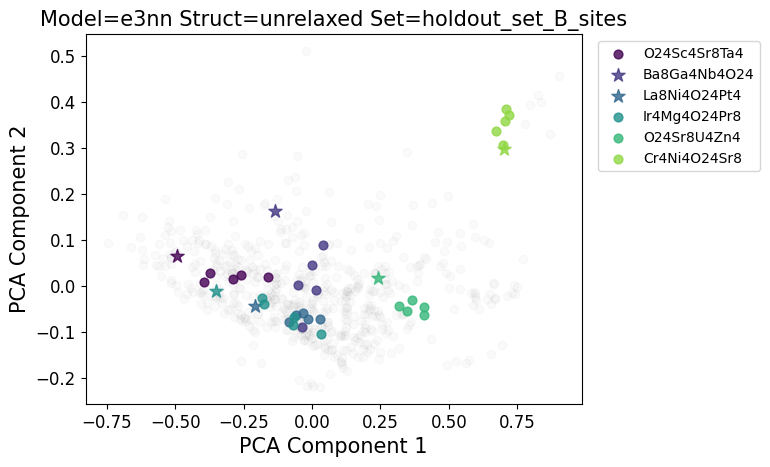

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

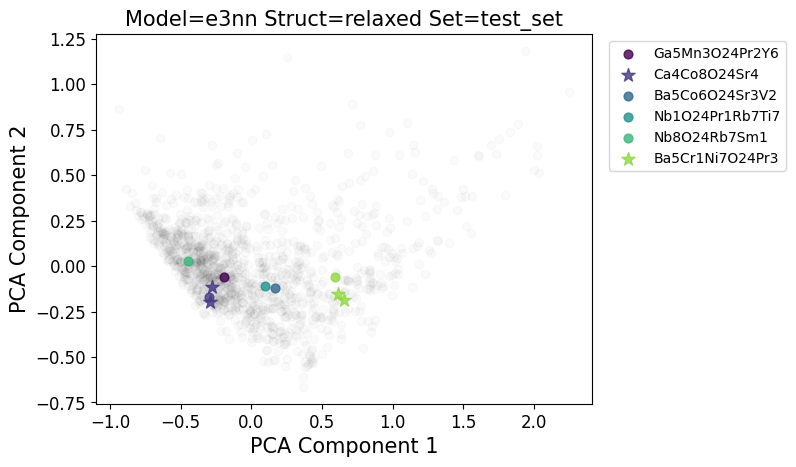

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

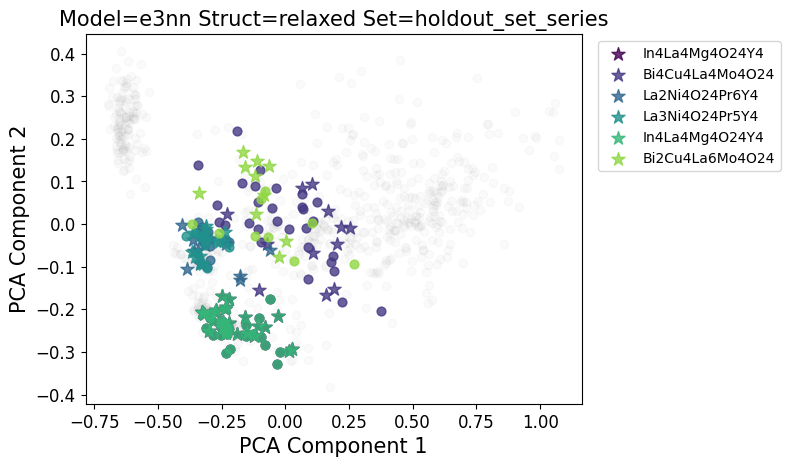

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

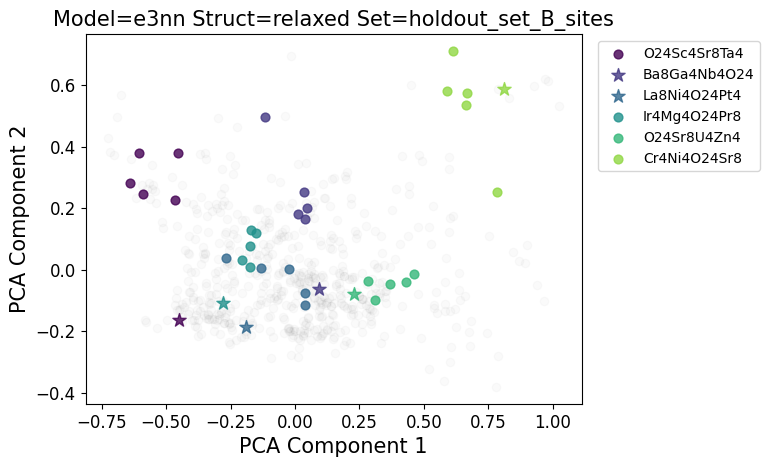

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

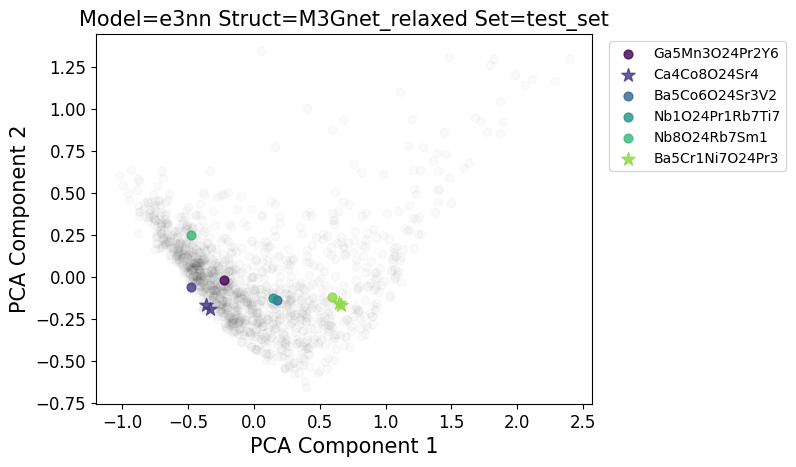

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

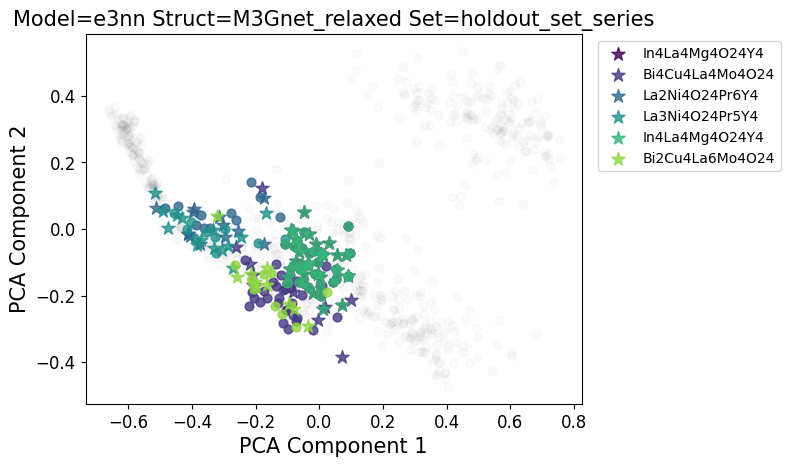

/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_2709181/518815102.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

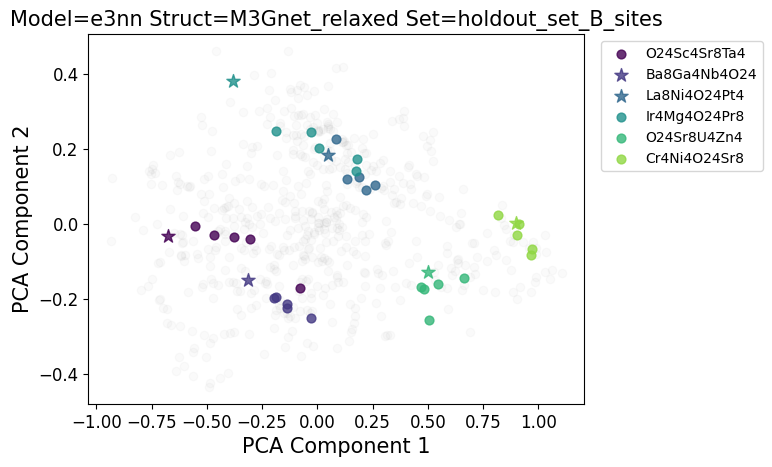

In [69]:
for param in all_params:
    for test in all_tests:
        get_pca(param,test)

NameError: name 'struct' is not defined